In [49]:
import sys
sys.path.append("noise-reduction")

In [154]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import enum
import numpy as np
import os
from dataclasses import dataclass
import PIL.Image

from noise_reducers.supervised_noise_reducer import NoiseReducerStatistics

In [51]:
plt.style.use("ggplot")

In [46]:
class ReducerType(enum.Enum):
    GIBBS = 1
    GRADIENT = 2


def load_experiment_statistics(experiment, reducer_type):
    reducer_name = (
        "binary_gibbs_reducer" if reducer_type == ReducerType.GIBBS
        else "binary_gradient_reducer"
    )
    path = os.path.join(
        "binary_images",
        experiment.experiment_name,
        f"{reducer_name}_{round(experiment.noise_level * 100)}",
        "average_statistics.pickle"
    )
    with open(path, mode="rb") as file_stream:
        return pickle.load(file_stream)

In [52]:
@dataclass
class Experiment(object):
    experiment_name: str
    noise_level: float
    subtitle: str

In [144]:
def plot_per_experiment_evaluation_losses(experiments, init_values, figsize=(16, 8)):
    unused_figure, axes = plt.subplots(nrows=1, ncols=len(experiments), figsize=figsize)
    for ax, experiment, init_value in zip(axes, experiments, init_values):
        gibbs_statistics = load_experiment_statistics(experiment, ReducerType.GIBBS)
        gibbs_losses = [init_value] + gibbs_statistics.evaluation_losses
        iterations = 6000 * np.arange(len(gibbs_losses))
        ax.plot(iterations, gibbs_losses)
        gradient_statistics = load_experiment_statistics(experiment, ReducerType.GRADIENT)      
        gradient_losses = [init_value] + gradient_statistics.evaluation_losses
        ax.plot(iterations, gradient_losses)
        ax.set_xlabel("Iteration", labelpad=8, fontsize=13)
        ax.set_ylabel("Evaluation loss", labelpad=8, fontsize=13)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))        
        ax.set_title(f"Average evaluation loss for {experiment.subtitle}", y=1.02, fontsize=14)             
        ax.legend(["Gibbs sampling", "Gradient-based sampling"])        
    plt.show()

## Measuring the impact of input image size 

In [132]:
INPUT_SIZE_EXPERIMENTS = [
    Experiment(
        experiment_name="300x300_medium_noise10", noise_level=0.1,
        subtitle="images of size 300x300"
    ),
    Experiment(
        experiment_name="1000x1000_medium_noise10", noise_level=0.1,
        subtitle="images of size 1000x1000"
    ),
]

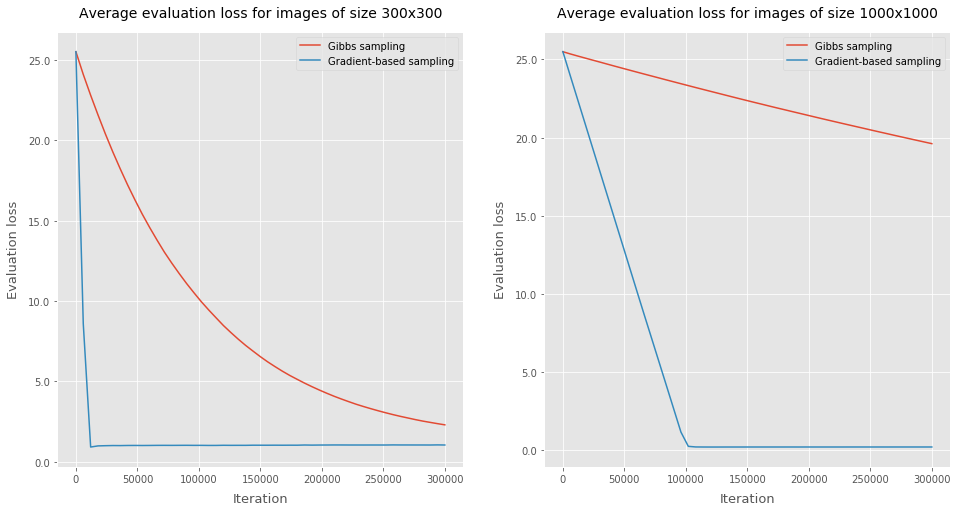

In [133]:
plot_per_experiment_evaluation_losses(
    INPUT_SIZE_EXPERIMENTS, init_values=[25.5, 25.5]
)

## Measuring the impact of image difficulty

In [134]:
IMAGE_DIFFICULTY_SIZE_EXPERIMENTS = [
    Experiment(
        experiment_name="300x300_easy_noise10", noise_level=0.1,
        subtitle="xxxx"
    ),
    Experiment(
        experiment_name="300x300_hard_noise10", noise_level=0.1,
        subtitle="yyyy"
    ),
]

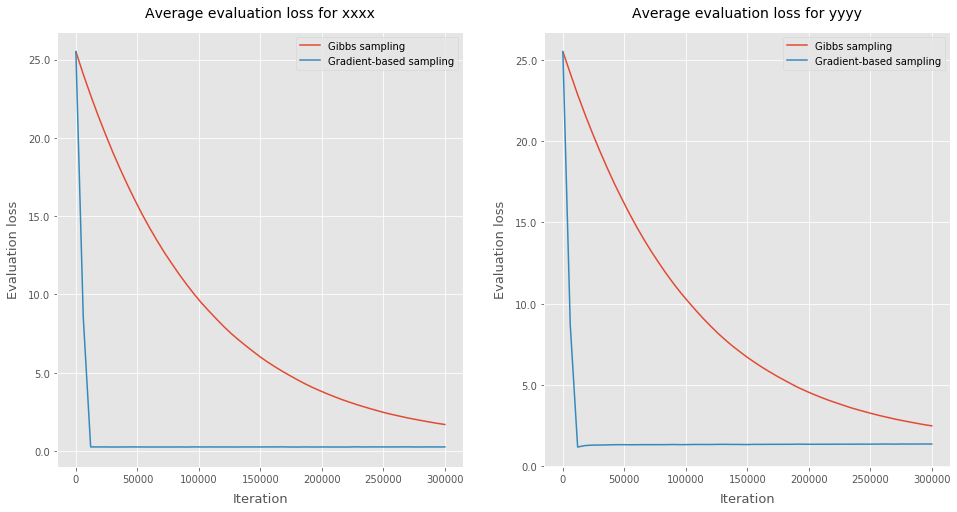

In [135]:
plot_per_experiment_evaluation_losses(
    IMAGE_DIFFICULTY_SIZE_EXPERIMENTS, init_values=[25.5, 25.5]
)

## Measure the impact of noise level

In [136]:
NOISE_LEVEL_EXPERIMENTS = [
    Experiment(
        experiment_name="300x300_medium_noise5", noise_level=0.05,
        subtitle="noise level of 0.05"
    ),
    Experiment(
        experiment_name="300x300_medium_noise10", noise_level=0.1,
        subtitle="noise level of 0.10"
    ),
    Experiment(
        experiment_name="300x300_medium_noise15", noise_level=0.15,
        subtitle="noise level of 0.15"
    ),    
]

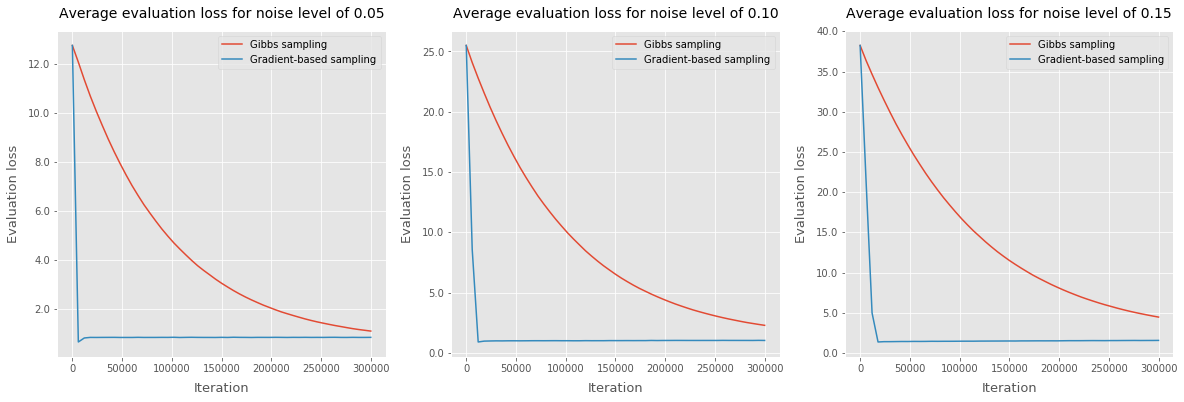

In [137]:
plot_per_experiment_evaluation_losses(
    NOISE_LEVEL_EXPERIMENTS, init_values=[12.75, 25.5, 38.25], figsize=(20, 6)
)

## Measure the sensitivity of noise level prior

In [199]:
NOISE_LEVEL_PRIOR_EXPERIMENTS = [
    Experiment(
        experiment_name="300x300_medium_noise15", noise_level=0.01,
        subtitle="noise level prior of 0.01"
    ),
    Experiment(
        experiment_name="300x300_medium_noise15", noise_level=0.05,
        subtitle="noise level prior of 0.05"
    ),
    Experiment(
        experiment_name="300x300_medium_noise15", noise_level=0.15,
        subtitle="noise level prior of 0.15"
    ),    
    Experiment(
        experiment_name="300x300_medium_noise15", noise_level=0.25,
        subtitle="noise level prior of 0.25"
    ),    
    Experiment(
        experiment_name="300x300_medium_noise15", noise_level=0.35,
        subtitle="noise level prior of 0.35"
    ),        
]

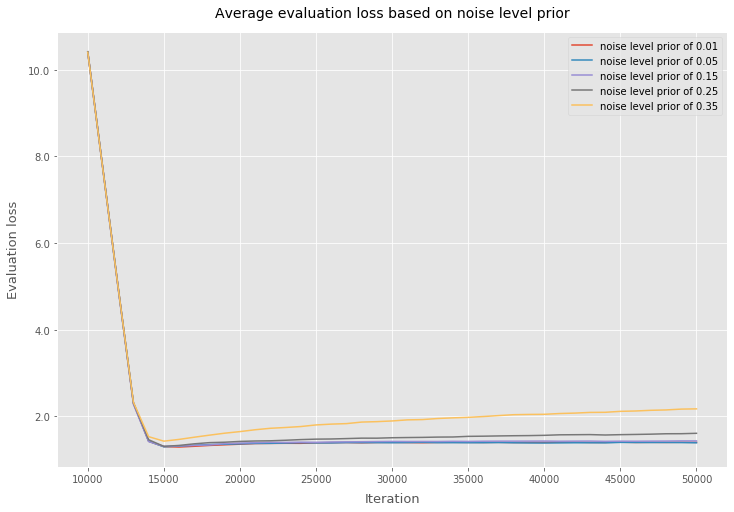

In [201]:
def plot_ggradient_evaluation_losses(experiments, title_suffix, init_values, figsize=(16, 8)):
    unused_figure, ax = plt.subplots(figsize=figsize)
    for experiment, init_value in zip(experiments, init_values):
        gradient_statistics = load_experiment_statistics(experiment, ReducerType.GRADIENT)      
        gradient_losses = [init_value] + gradient_statistics.evaluation_losses
        iterations = 1000 * np.arange(len(gradient_losses))
        ax.plot(iterations[10:], gradient_losses[10:])
    ax.set_xlabel("Iteration", labelpad=8, fontsize=13)
    ax.set_ylabel("Evaluation loss", labelpad=8, fontsize=13)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))        
    ax.set_title(f"Average evaluation loss based on {title_suffix}", y=1.02, fontsize=14)             
    ax.legend([experiment.subtitle for experiment in experiments])
    plt.show()


plot_ggradient_evaluation_losses(
    NOISE_LEVEL_PRIOR_EXPERIMENTS,
    title_suffix="noise level prior",
    init_values=[38.25] * len(NOISE_LEVEL_PRIOR_EXPERIMENTS),
    figsize=(12, 8)
)

## Dataset examples

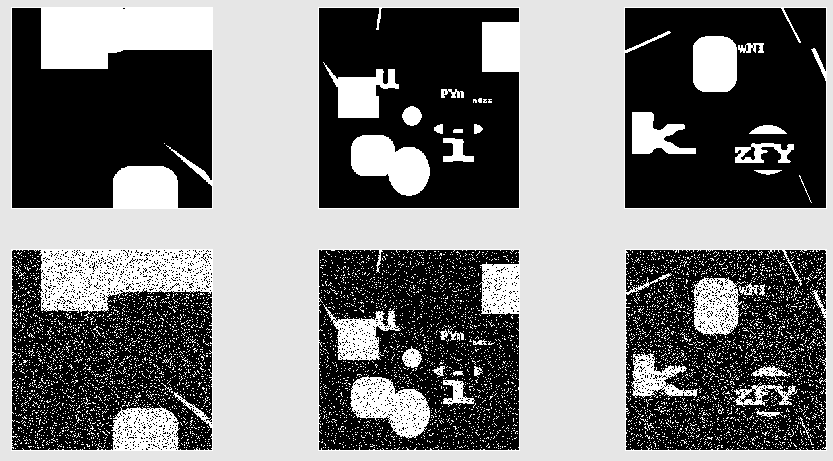

In [198]:
def plot_dataset_examples():
    figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 7))
    figure.patch.set_facecolor((0.9, 0.9, 0.9))
    figure.subplots_adjust(wspace=0.1, bottom=0.0)
    for row in range(2):
        for column in range(3):
            type_of_image = "ground_truth" if row == 0 else "observation"
            image = PIL.Image.open(f"examples/{column}_{type_of_image}.png")
            axes[row, column].grid(False)
            axes[row, column].tick_params(labelbottom=False, labelleft=False)    
            axes[row, column].imshow(image, cmap='gray')
            axes[row, column].set_xticks([])
            axes[row, column].set_yticks([])
plot_dataset_examples()

## Qualitative results

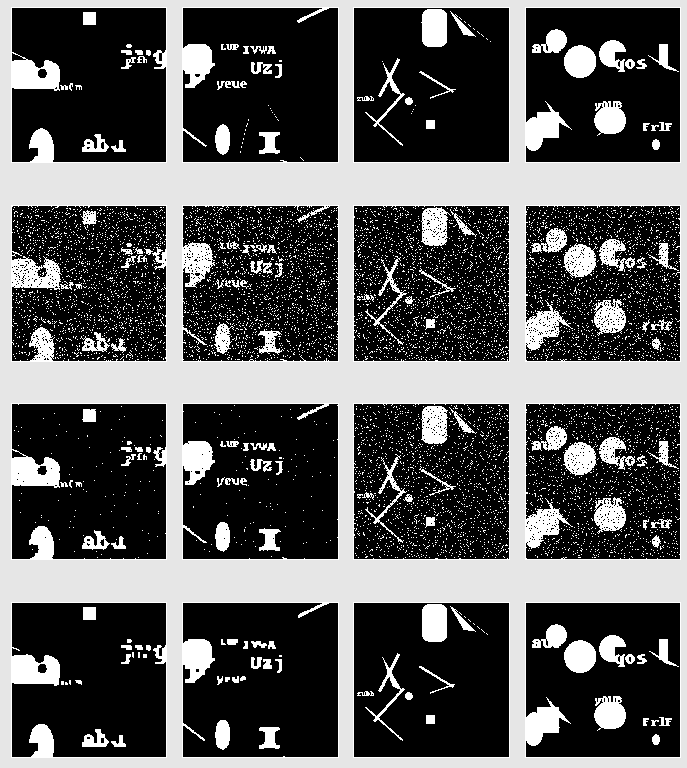

In [205]:
def qualitative_type_of_image(index):
    if index == 0:
        return "ground_truth"
    elif index == 1:
        return "observation"
    elif index == 2:
        return "binary_gibbs"
    elif index == 3:
        return "binary_gradient"
    else:
        raise ValueError("Invalid index")


def plot_qualitative_results():
    figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12))
    figure.patch.set_facecolor((0.9, 0.9, 0.9))
    figure.subplots_adjust(wspace=0.1, bottom=0.0)
    for row in range(4):
        for column in range(4):
            type_of_image = qualitative_type_of_image(row)
            image = PIL.Image.open(f"binary_results/{column}_{type_of_image}.png")
            axes[row, column].grid(False)
            axes[row, column].tick_params(labelbottom=False, labelleft=False)    
            axes[row, column].imshow(image, cmap='gray')
            axes[row, column].set_xticks([])
            axes[row, column].set_yticks([])


plot_qualitative_results()

## Grayscale images - dataset examples

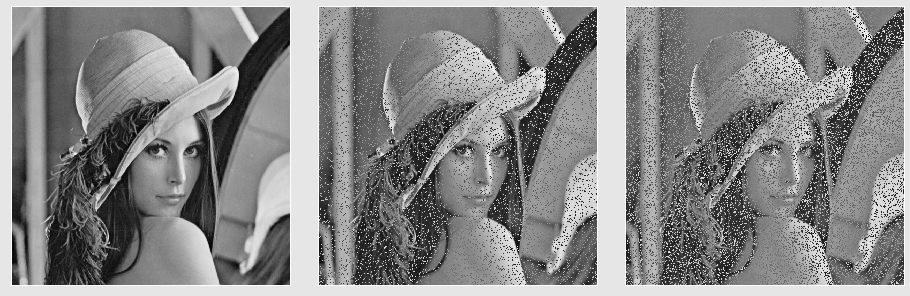

In [213]:
def grayscale_column_to_example(index):
    if index == 0:
        return "ground_truth"
    elif index == 1:
        return "observation_noise10"
    elif index == 2:
        return "observation_noise20"
    else:
        raise ValueError("Invalid index")


def plot_grayscale_dataset_examples():
    figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
    figure.patch.set_facecolor((0.9, 0.9, 0.9))
    figure.subplots_adjust(wspace=0.1, bottom=0.0)
    for column in range(3):
        type_of_image = grayscale_column_to_example(column)
        image = PIL.Image.open(f"grayscale_examples/0_{type_of_image}.png")
        axes[column].grid(False)
        axes[column].tick_params(labelbottom=False, labelleft=False)    
        axes[column].imshow(image, cmap='gray')
        axes[column].set_xticks([])
        axes[column].set_yticks([])


plot_grayscale_dataset_examples()

## Grayscale images - denoising quality

In [220]:
GRAYSCALE_EXPERIMENTS = [
    Experiment(
        experiment_name="size800_noise10_flipped", noise_level=0.1,
        subtitle="noise level of 0.1"
    ),
    Experiment(
        experiment_name="size800_noise20_flipped", noise_level=0.2,
        subtitle="noise level of 0.2"
    ),
]

In [221]:
def load_grayscale_experiment_statistics(experiment, reducer_type):
    reducer_name = (
        "grayscale_gibbs_reducer" if reducer_type == ReducerType.GIBBS
        else "grayscale_gradient_reducer"
    )
    path = os.path.join(
        "grayscale_images",
        experiment.experiment_name,
        f"{reducer_name}_{round(experiment.noise_level * 100)}",
        "average_statistics.pickle"
    )
    with open(path, mode="rb") as file_stream:
        return pickle.load(file_stream)
    

def plot_grayscale_experiments_evaluation_losses(experiments, init_values, figsize=(16, 8)):
    unused_figure, axes = plt.subplots(nrows=1, ncols=len(experiments), figsize=figsize)
    for ax, experiment, init_value in zip(axes, experiments, init_values):
        gibbs_statistics = load_grayscale_experiment_statistics(experiment, ReducerType.GIBBS)
        gibbs_losses = [init_value] + gibbs_statistics.evaluation_losses
        iterations = 6000 * np.arange(len(gibbs_losses))
        ax.plot(iterations, gibbs_losses)
        gradient_statistics = load_grayscale_experiment_statistics(
            experiment, ReducerType.GRADIENT
        )      
        gradient_losses = [init_value] + gradient_statistics.evaluation_losses
        ax.plot(iterations, gradient_losses)
        ax.set_xlabel("Iteration", labelpad=8, fontsize=13)
        ax.set_ylabel("Evaluation loss", labelpad=8, fontsize=13)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))        
        ax.set_title(f"Average evaluation loss for {experiment.subtitle}", y=1.02, fontsize=14)             
        ax.legend(["Gibbs sampling", "Gradient-based sampling"])        
    plt.show()

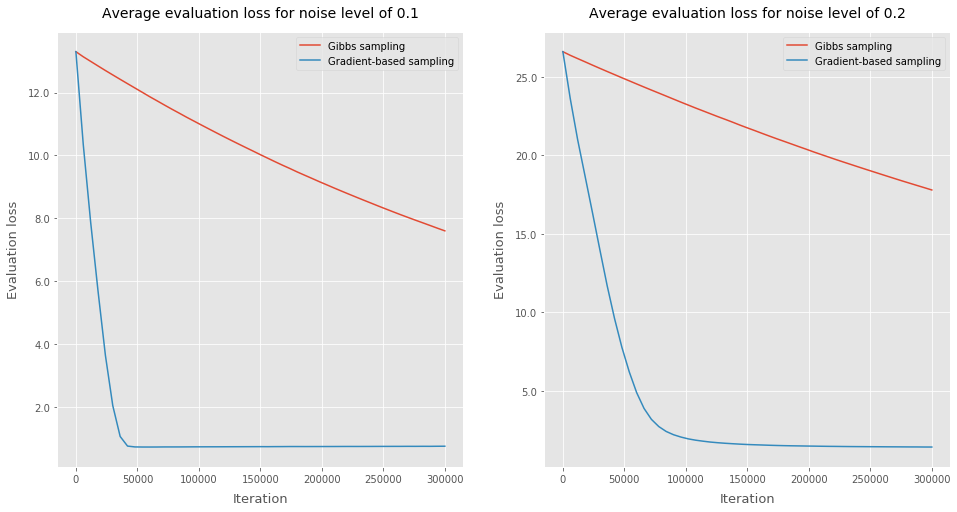

In [227]:
plot_grayscale_experiments_evaluation_losses(
    GRAYSCALE_EXPERIMENTS, init_values=[13.3, 26.6]
)

## Grayscale images - qualitative results

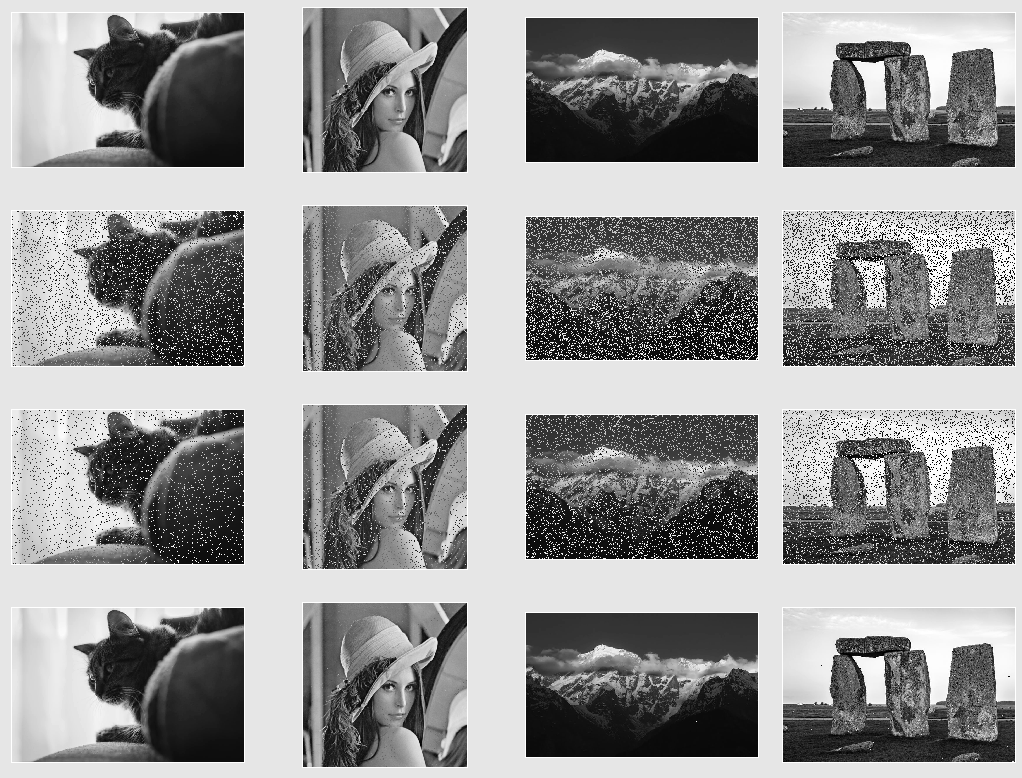

In [222]:
def grayscale_qualitative_type(index):
    if index == 0:
        return "ground_truth"
    elif index == 1:
        return "observation"
    elif index == 2:
        return "grayscale_gibbs"
    elif index == 3:
        return "grayscale_gradient"
    else:
        raise ValueError("Invalid index")


def plot_grayscale_qualitative_results():
    figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 12))
    figure.patch.set_facecolor((0.9, 0.9, 0.9))
    figure.subplots_adjust(wspace=0.1, bottom=0.0)
    for row in range(4):
        for column in range(4):
            type_of_image = grayscale_qualitative_type(row)
            image = PIL.Image.open(f"grayscale_results/{column}_{type_of_image}.png")
            axes[row, column].grid(False)
            axes[row, column].tick_params(labelbottom=False, labelleft=False)    
            axes[row, column].imshow(image, cmap='gray')
            axes[row, column].set_xticks([])
            axes[row, column].set_yticks([])


plot_grayscale_qualitative_results()